In [1]:
import torch.nn as nn
import torch.nn.functional as F
import math

class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 70
        _num2           = 40
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)
        
        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.Sigmoid())
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        
        self._initialize_weight()        
        
    def _initialize_weight(self):

        for name,m in self._modules.items():
            if isinstance(m,nn.Linear):
                n = m.in_features
                m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [2]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

# -----------------------------------------------------------------------------
# load dataset
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),   
                                transforms.ToTensor(),])

train_data_path = 'horse-or-human/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
loader_train = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=1)  

validation_data_path = 'horse-or-human/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)

loader_test = torch.utils.data.DataLoader(valset, batch_size=10, shuffle=True, num_workers=1)


# -----------------------------------------------------------------------------


num_classes = 2

# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------
model = Linear(num_classes=num_classes)

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 1

if bCuda:
 
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

optimizer   = optim.SGD(model.parameters() , lr=0.015, weight_decay=0.06)
objective   = nn.CrossEntropyLoss()

# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():

    # print('train the model at given epoch')

    loss_train          = []
    accuracy_train      = []

    model.train()

    correct = 0
    correct_batch = 0
    for idx_batch, (data, target) in enumerate(loader_train):
        
        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        # 밑에는 x,y 인풋들
        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()

        output  = model(data)
        loss    = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item()
        loss_train.append(loss_train_batch)
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()
        correct_batch = pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy_train_batch = float(correct_batch) / len(data)
        accuracy_train.append(accuracy_train_batch)
        
    loss_train_mean     = np.mean(loss_train)  # mean loss
    loss_train_std      = np.std(loss_train)   # std
    accuracy_train_mean =100. * float(correct) / len(loader_train.dataset)  # mean accuracy
    accuracy_train_std  =100. * np.std(accuracy_train)
    # print(loss_train_mean)
    # print(accuracy_train_mean)

    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 
            'accuracy_train_mean': accuracy_train_mean, 'accuracy_train_std': accuracy_train_std}

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(loader_test):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test / len(loader_test.dataset)
    accuracy_test   = 100. * float(correct) / len(loader_test.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------

loss_train_mean, loss_train_std, loss_test, accuracy_test ,accuracy_train_mean, accuracy_train_std = [], [], [], [], [], []
past=0
for e in range(3000):
    if e > 50:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001
    result_train    = train()
    result_test     = test()
    
    loss_train_mean.append(result_train['loss_train_mean'])

    loss_train_std.append(result_train['loss_train_std'])
    loss_test.append(result_test['loss_test'])
    accuracy_test.append(result_test['accuracy_test'])
    accuracy_train_mean.append(result_train['accuracy_train_mean'])
    accuracy_train_std.append(result_train['accuracy_train_std'])
    
    print("[epoch ",e,"] loss: (training) ",result_train['loss_train_mean'],", (testing) ",result_test['loss_test'],"accuracy: (training)",result_train['accuracy_train_mean'],",(testing)",result_test['accuracy_test'])
    if abs(past -result_train['loss_train_mean']) < 10e-6:
        print("finish")
        break
    else :
        past=result_train['loss_train_mean']
        continue
        
    


[epoch  0 ] loss: (training)  0.6860960183791744 , (testing)  0.06862133764661849 accuracy: (training) 53.65141187925998 ,(testing) 50.0
[epoch  1 ] loss: (training)  0.6751992517304652 , (testing)  0.06636931514367461 accuracy: (training) 55.98831548198637 ,(testing) 59.765625
[epoch  2 ] loss: (training)  0.6634188444869032 , (testing)  0.06349778897128999 accuracy: (training) 62.512171372930865 ,(testing) 88.28125
[epoch  3 ] loss: (training)  0.6443434670133498 , (testing)  0.05995991523377597 accuracy: (training) 65.43330087633885 ,(testing) 87.5
[epoch  4 ] loss: (training)  0.6284779883125453 , (testing)  0.056211686693131924 accuracy: (training) 70.88607594936708 ,(testing) 85.9375
[epoch  5 ] loss: (training)  0.6037867838896595 , (testing)  0.053099192096851766 accuracy: (training) 73.12560856864654 ,(testing) 86.328125
[epoch  6 ] loss: (training)  0.5826924266745743 , (testing)  0.052122068707831204 accuracy: (training) 75.46251217137294 ,(testing) 83.984375
[epoch  7 ] los

TypeError: unsupported operand type(s) for /: 'list' and 'int'

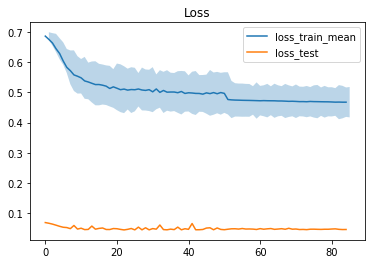

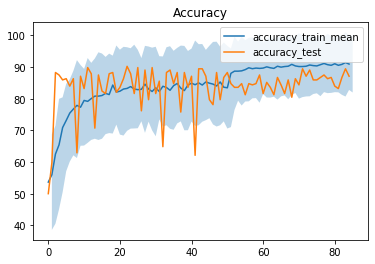

In [5]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.plot(loss_train_mean)
plt.plot(loss_test)
plt.fill_between(np.arange(1,len(loss_train_mean)+1), np.array(loss_train_mean) - np.array(loss_train_std),np.array(loss_train_mean) + np.array(loss_train_std), alpha = 0.3)
plt.legend(['loss_train_mean','loss_test'])
plt.show()


plt.title("Accuracy")
plt.plot(accuracy_train_mean)
plt.plot(accuracy_test)
plt.fill_between(np.arange(1,len(accuracy_train_mean)+1), np.array(accuracy_train_mean) - np.array(accuracy_train_std),np.array(accuracy_train_mean) + np.array(accuracy_train_std), alpha = 0.3)
plt.legend(['accuracy_train_mean','accuracy_test'])
plt.show()

(0.0, 1.0, 0.0, 1.0)

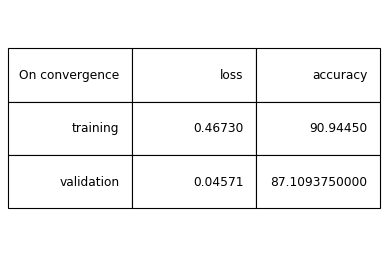

In [7]:
fig = plt.figure(dpi=80)
ax = fig.add_subplot(1,1,1)
table_data=[
    ['On convergence', "loss", "accuracy"],
    ["training", "{0:.5f}".format(loss_train_mean[len(loss_train_mean)-1]), "{0:.5f}".format(accuracy_train_mean[len(accuracy_train_mean)-1])],
    ["validation", "{0:.5f}".format(loss_test[len(loss_test)-1]), "{0:.10f}".format(accuracy_test[len(accuracy_test)-1])]
]
table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(14)
table.scale(1,4)
ax.axis('off')